In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('https://raw.githubusercontent.com/MATF-istrazivanje-podataka-1/2023_Data_Mining_Chess_Dataset/main/Preprocessing/preprocessed_set(1).csv')

In [ ]:
data.head()
data.drop(columns=['Unnamed: 0'],inplace=True)
indexes=data[data['winner']==0]

In [ ]:
data.winner.unique()

array([0, 1])

# Klasifikacija

Zelimo da postupkom kalsifikacije na osnovu podataka iz tabele predvidimo da li je pobedio crni ili beli. U skupu nema neresenih

<BarContainer object of 2 artists>

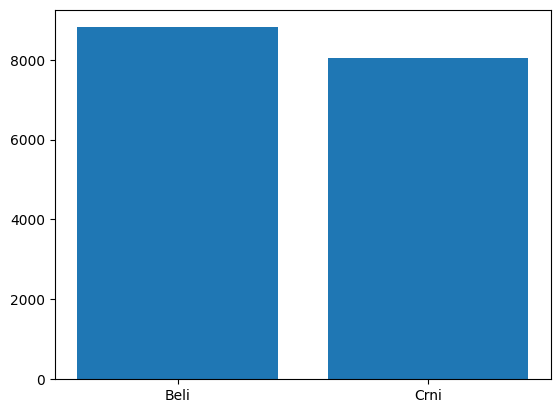

In [ ]:
d=data.winner.value_counts()
plt.bar(["Beli","Crni"],[d.iloc[0],d.iloc[1]])

In [ ]:
len(data)

16865

Klase su balansirane u odnosu 52-48% u korist belog i zato nece biti potrebe za uzorkovanjem

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score

##Konverzija otvaranja (ovo prebaciti u preprocesiranje)

In [22]:
otvaranja=data['opening_eco']
def convert_op_eco(s):
  s=s.strip()
  return (ord(s[0])-ord('A')+1)*100+int(s[1]+s[2])
otvaranja
print(convert_op_eco('Z20'))
otv_int=list(map(convert_op_eco,otvaranja))
data['opening_eco']=otv_int
data.head()

2620


,rated,turns,victory_status,winner,white_rating,black_rating,opening_eco,opening_ply,increment_code
0,1,16,1,0,1322,1261,200,4,2
1,1,61,2,1,1439,1454,402,3,2
2,1,95,2,1,1523,1469,341,5,3
3,1,33,1,1,1520,1423,400,10,2
4,0,9,1,0,1413,2108,200,5,3


##Podela na ulazne i ciljne atribute:

In [23]:
Y = data['winner']
X = data.drop(columns=['winner'])
feature_names = X.columns
X.shape
Y.value_counts()

1    8812
0    8053
Name: winner, dtype: int64

##Podela na test i trening skupove:

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

In [17]:
def report(y_real, y_pred):
    print('Confusion matrix:')
    print(confusion_matrix(y_real, y_pred))
    print('Accuracy score:')
    print(accuracy_score(y_real, y_pred))
    print('Precision score: ')
    print(precision_score(y_real, y_pred))
    print('Recall score: ')
    print(recall_score(y_real, y_pred))
def new_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)

    print('Train data:\n')
    y_train_pred = model.predict(X_train)
    report(y_train, y_train_pred)
    
    print('\n--------------------------------------\n')

    print('Test data:\n')
    y_pred = model.predict(X_test)
    report(y_test, y_pred)

    return model

In [25]:
from sklearn import tree
dtc = tree.DecisionTreeClassifier(random_state=55)
dtc = new_model(dtc, X_train, X_test, Y_train, Y_test)
#error zbog otvaranja

Train data:

Confusion matrix:
[[6020    0]
 [   0 6628]]
Accuracy score:
1.0
Precision score: 
1.0
Recall score: 
1.0

--------------------------------------

Test data:

Confusion matrix:
[[1184  849]
 [ 815 1369]]
Accuracy score:
0.6054066872184017
Precision score: 
0.6172227231740307
Recall score: 
0.6268315018315018


Pokusano je i sa modelima gde je velicina test skupa 20% i 30% velicine originalnog skupa. Ova podela nam daje najbolje rezultate

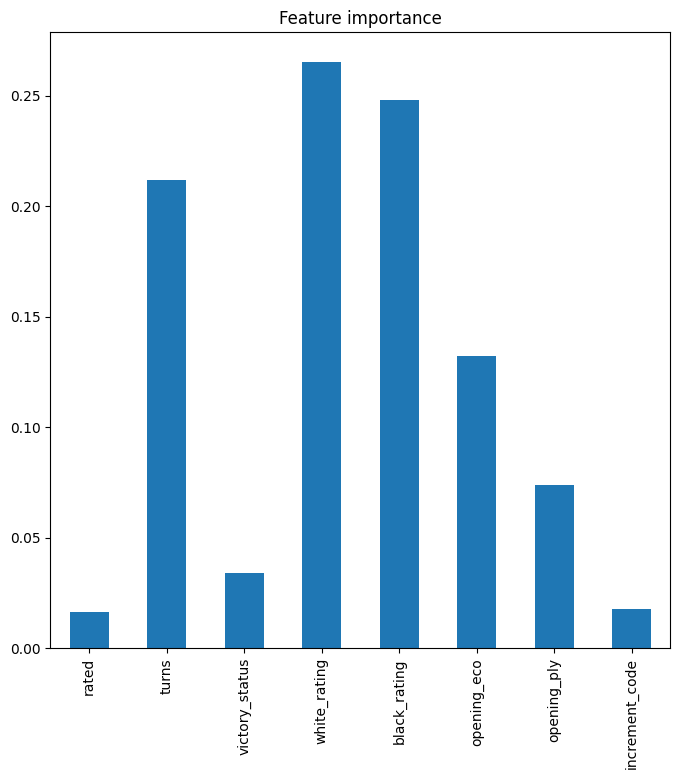

In [28]:
plt.figure(figsize=(8, 8))
pd.Series(dtc.feature_importances_, index=X_train.columns).plot.bar()
plt.title("Feature importance")
plt.show()

Buduci da smo dobili veoma neprecizan model pokusacemo da uvedemo neke statistike da bismo mogli lakse da predvidimo pobednika. Smatra se da je u sahu losa praksa da se igra kraljicom u prvih par poteza pa cemo da vidimo da li njeno pomeranje moze da utice na rezultat partije.

In [44]:
import joblib
file_path='../rezultati_preprocesiranja.joblib'
data2, podaci = joblib.load(file_path)
data2.head()

,rated,turns,victory_status,winner,white_rating,black_rating,opening_eco,opening_ply,increment_code
1,1,16,1,0,1322,1261,B00,4,2
3,1,61,2,1,1439,1454,D02,3,2
4,1,95,2,1,1523,1469,C41,5,3
6,1,33,1,1,1520,1423,D00,10,2
7,0,9,1,0,1413,2108,B00,5,3


In [48]:
# prva_partija=podaci.iloc[0]
# prva_partija=prva_partija.split()[:16]
# prva_partija
podaci.iloc[0]

'd4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5 Bf4'

Ovaj model je dosta neprecizan. Pokusacemo da poboljsamo model podesavanjem hiperparametara pomocu unakrsne validacije

#GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV
params = {'criterion': ['gini', 'entropy'],
          'max_depth': [2,4,6, 8]
         }
estimator = GridSearchCV(DecisionTreeClassifier(random_state=55), param_grid=params, cv=3)
estimator.fit(X_train, Y_train)
estimator.best_params_

{'criterion': 'entropy', 'max_depth': 8}

In [ ]:
estimator.best_score_

0.6355154965211892

In [ ]:
estimator=new_model(estimator,X_train, X_test, Y_train, Y_test)

Train data:

Confusion matrix:
[[3700 2312]
 [1729 4907]]
Accuracy score:
0.6805028462998103
Precision score: 
0.6797340351849287
Recall score: 
0.739451476793249

--------------------------------------

Test data:

Confusion matrix:
[[1142  899]
 [ 672 1504]]
Accuracy score:
0.6274602798197771
Precision score: 
0.6258843112775697
Recall score: 
0.6911764705882353


#Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=2)
random_forest.fit(X_train, Y_train)
random_forest = new_model(random_forest, X_train, X_test, Y_train, Y_test)


Train data:

Confusion matrix:
[[5832  180]
 [1777 4859]]
Accuracy score:
0.8452719797596457
Precision score: 
0.9642786267116491
Recall score: 
0.732218203737191

--------------------------------------

Test data:

Confusion matrix:
[[1573  468]
 [1278  898]]
Accuracy score:
0.5859615840645008
Precision score: 
0.657393850658858
Recall score: 
0.41268382352941174


Slucajna suma sa 50 stabala

In [ ]:
random_forest_50_trees = RandomForestClassifier(n_estimators=50, random_state=42)
random_forest_50_trees.fit(X_train, Y_train)
random_forest_50_trees = new_model(random_forest_50_trees, X_train, X_test, Y_train, Y_test)


Train data:

Confusion matrix:
[[6012    0]
 [   0 6636]]
Accuracy score:
1.0
Precision score: 
1.0
Recall score: 
1.0

--------------------------------------

Test data:

Confusion matrix:
[[1286  755]
 [ 687 1489]]
Accuracy score:
0.6580507469765235
Precision score: 
0.6635472370766489
Recall score: 
0.6842830882352942


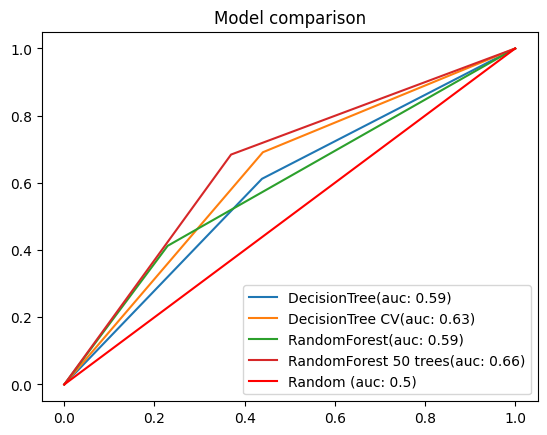

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
models = [dtc, estimator.best_estimator_, random_forest,random_forest_50_trees]
model_names = ['DecisionTree', 'DecisionTree CV',  'RandomForest', 'RandomForest 50 trees']
for model, model_name in zip(models, model_names):
    y_pred = model.predict(X_test)
    fpr,tpr, _ = roc_curve(Y_test, y_pred)
    auc = roc_auc_score(Y_test, y_pred)
    lab = model_name + "(auc: " + str(round(auc, 2)) + ")"
    plt.plot(fpr, tpr, label=lab)

plt.plot([0, 1], [0, 1], label='Random (auc: 0.5)', color='red')
plt.title("Model comparison")
plt.legend()
plt.show()


In [ ]:
modeli=[dtc,estimator.best_estimator_,random_forest,random_forest_50_trees]

In [ ]:
from joblib import dump
dump(modeli, 'decision_trees_modeli.joblib')

['decision_trees_modeli.joblib']

In [ ]:
import os
print(os.getcwd())
#ovde su je moj joblib fajl


/content
